# Image Feature Engineering with Pre-Trained Neural Networks

Deep convolutional neural networks (CNN) are pre-trained on public datasets with millions of images. For example, the famous [ImageNet](http://www.image-net.org) catalogue consists of not less than 24 million images. Such pre-trained networks (i.e. their architecture and weights) are made avaiable for transfer learning (specialization to a specific domain by re-training, see later in this course) or as feature extractors for other machine learning purposes. The architecture of general-purpose CNNs is such that they first learn a compact encoding or representation of input images (e.g. numeric vector of 2048 dimensions) before they map the encoded image to the final category. A CNNs can thus be used for feature engineering by feeding it new images and extract their encodings from one of the inner layers. In this exercise, we use such a pre-trained CNN to encode images from a separate dataset and use the image feature vectors for image similarity computation much like it would be implemented in an image retrieval application with not keywords or captions available. The dataset used in the exercise consists of a small subset from the [Corel](https://sites.google.com/site/dctresearch/Home/content-based-image-retrieval) image database. It consists of 10 concept groups of images where each is composed by 100 images. The dataset is publicly available on [Kaggle](https://www.kaggle.com/elkamel/corel-images).

In [4]:
import os
import numpy as np
import matplotlib.image
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

# Run pip install --upgrade tensorflow_hub if necessary
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.neighbors import NearestNeighbors

# Library for progress bars
from tqdm.auto import tqdm

# Interactive elements for Jupyter notebooks
from ipywidgets import interact

# Make sure you have the right tensorflow version installed
print (tf.__version__)

2.1.0


## Parameters

In [6]:
dataset_path = Path(os.getcwd()) / "dataset"

# Where to load train and test images from
train_path  = dataset_path / "training_set"
test_path   = dataset_path / "test_set"

# Where to save image emeddings
embeds_path = dataset_path / "embeddings"

print("Default dataset path: {}".format(dataset_path))
print("Train path: {}".format(train_path))
print("Test path: {}".format(test_path))
print("Embeds path: {}".format(embeds_path))

Default dataset path: /Users/stofers/Development/HSLU/ADML/09 CNN - Exercises/dataset
Train path: /Users/stofers/Development/HSLU/ADML/09 CNN - Exercises/dataset/training_set
Test path: /Users/stofers/Development/HSLU/ADML/09 CNN - Exercises/dataset/test_set
Embeds path: /Users/stofers/Development/HSLU/ADML/09 CNN - Exercises/dataset/embeddings


## Helper Methods

This method loads an image from a given path using tensorflow methods

In [7]:
def load_image(path):
    img = Image.open(path)
    img = img.resize((img_height, img_width))
    img = np.array(img)
    img = img / 255
    return img

This method plots 9 random images in a grid

In [8]:
def plot_nine_random_images(images, labels):
    plt.figure(figsize=(10, 10))
    # Loop over the dataset by taking one image and label at a time
    for i in range(9):
        img_index = np.random.randint(0, len(images))
        # We display a 3x3 grid of images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[img_index], cmap="gray")
        plt.title(labels[img_index])

This method returns all images in a given path

In [9]:
def return_image_file_names(path):
    return_files = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if name.split(".")[-1] == "jpg":
                file_path = os.path.join(root, name)
                folder_name = root.split("/")[-1]
                return_files.append([file_path, folder_name])
    return return_files

# Part 1: Generate Image Feature Vectors

To calculate similarty between images, they must first be encoded into a feature vector. There are many ways of doing this. The computer vision community for example proposed Scale-Invariant Feature Transform (SIFT), Speeded-Up Robust Features (SURF) or Features from Accelerated Segment Test (FAST). However, more recent approached use pre-trained CNNs as feature extractors as they can convincingly extract complex high-level features from images. For this purpose, we first load a pre-trained CNN from the TensorFlow hub.

### Loading Pre-Trained CNN

There are different pre-trained CNNs avaiable on the [TensorFlow hub](https://tfhub.dev/s?module-type=image-feature-vector). For this exercise we use a pre-trained Inception v3 model and extract the features from the last dense layer of the network. In case you want to try a different model, just make sure that you pass the correct input shape to the model. To load a pre-trained model, you only need the respective TensorFlow Hub URL.

In [10]:
# Which model to load
clf_name = "Inception_v3"
embedder_model = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"

# Shape of the model input
img_height   = 299
img_width    = 299
img_channels = 3

# Load model
embedder = tf.keras.Sequential()
embedder.add(hub.KerasLayer(embedder_model, trainable=False))

# Specify input shape (batch, height, width, channels)
embedder.build([None, img_height, img_width, img_channels])  

# Print model information
embedder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


### Load Image Dataset

The selected Inception v3 model thus generates 2048 dimensional feature vectors. Now we pass every image from our dataset to the model and extract the feature vectors. As you can imagine, this will takes some time. We show a progress bar and save this the extracted feature vectors to a file. For future experiments, you can just load the file and do not need to re-run the complete encoding process. Our dataset is split into *training* and *testing* images to be loaded separately. 

In [11]:
train_files  = return_image_file_names(train_path)
train_labels = [labels[1] for labels in train_files]
print('{} training image paths found'.format(len(train_files)))

900 training image paths found


In [12]:
test_files = return_image_file_names(test_path)
test_labels = [labels[1] for labels in test_files]
print('{} test image paths found'.format(len(test_files)))

100 test image paths found


In [13]:
train_images = np.array([load_image(str(f)) for f, _ in train_files])
print("{} training images loaded".format(len(train_images)))

900 training images loaded


In [14]:
test_images = np.array([load_image(str(f)) for f, _ in test_files])
print("{} test images loaded".format(len(test_images)))

100 test images loaded


In [15]:
print("Shape of the images: {}".format(train_images[0].shape))

# Make sure that the shapes of the images match the model input
assert train_images[0].shape == (img_height, img_width, img_channels)

Shape of the images: (299, 299, 3)


Let us display 9 randomly selected training images along with their label.

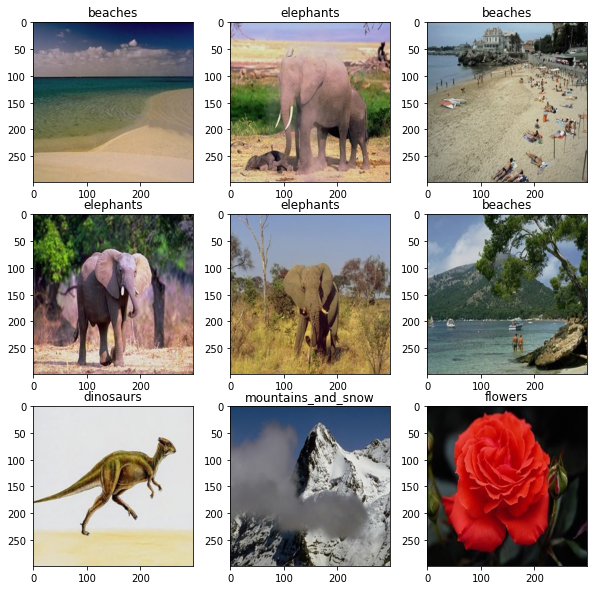

In [16]:
plot_nine_random_images(train_images, train_labels)

Let us extract the feature vector for a single image, e.g. image 100, for illustration.

In [17]:
image = train_images[100]

print('Dimensionality of a single image is:\t {}'.format(image.shape))

# Add one dimension to the front to accomodate model input format
image = image[np.newaxis, ...]

print('Dimensionality of the image is now:\t {}'.format(image.shape))

# Extract feature vector from CNN
vec = embedder.predict(image)

print('Dimensionality of feature vector is:\t {}'.format(vec.shape))

Dimensionality of a single image is:	 (299, 299, 3)
Dimensionality of the image is now:	 (1, 299, 299, 3)
Dimensionality of feature vector is:	 (1, 2048)


Now we encode the entire dataset of training and test images.

In [18]:
train_embeds = []
test_embeds  = []

# Extract feature vector for training images
for i in tqdm(range(len(train_images))):
    train_embeds.append(embedder.predict(train_images[i][np.newaxis, ...]).squeeze())
    
# Extract feature vector for test images
for i in tqdm(range(len(test_images))):
    test_embeds.append(embedder.predict(test_images[i][np.newaxis, ...]).squeeze())
    
train_embeds = np.asarray(train_embeds)
test_embeds  = np.asarray(test_embeds)

print("Shape embeddings train:\t {}".format(train_embeds.shape))
print("Shape embeddings test:\t {}".format(test_embeds.shape))


Shape embeddings train:	 (900, 2048)
Shape embeddings test:	 (100, 2048)


As a final step we will save the embedded dataset to our local drive, using the `np.savez()` function.

In [19]:
train_embedding_file_name = "embeds_train_{}.npz".format(clf_name)
train_persisted_embeds = Path(dataset_path / embeds_path / train_embedding_file_name)
np.savez(train_persisted_embeds, embeds=train_embeds, info=train_files)

In [20]:
test_embedding_file_name = "embeds_test_{}.npz".format(clf_name)
test_persisted_test = Path(dataset_path / embeds_path / test_embedding_file_name)
np.savez(test_persisted_test, embeds=test_embeds, info=test_files)

# Part 2: Image Similarity

We will now use the image feature vectors to compute similarity between images. As a first step, we load the embeddings from the files again using the `np.load()` function. For your projects we recommend to split part 1 and partb 2 over different notebooks as for larger image seits the extraction of feature vectors takes a lot of time. However, you can speed up when you have access to GPU resources of course. 

In [21]:
train_embeds_saved = np.load(dataset_path / embeds_path / train_embedding_file_name)
train_embeds = train_embeds_saved["embeds"]
train_info = train_embeds_saved["info"]
train_names = [f for f, _ in train_info]

test_embeds_saved = np.load(dataset_path / embeds_path / test_embedding_file_name)
test_embeds = test_embeds_saved["embeds"]
test_info = test_embeds_saved["info"]
test_names = [f for f, _ in test_info]

print("Train shape:\t {0}\nTest shape:\t {1}".format(train_embeds.shape, test_embeds.shape))

Train shape:	 (900, 2048)
Test shape:	 (100, 2048)


We use k-nearest neighbors (k-NN) along with the cosine distance to obtain the $k=3$ most similar images.

In [22]:
knn = NearestNeighbors(n_neighbors=3, metric='cosine')

# Fit k-NN on the training set
knn.fit(train_embeds)

NearestNeighbors(metric='cosine', n_neighbors=3)

Finally, use the trained k-NN model to make predictions on the unseen test set and plot the three most similar images along with their respective distance to the input image and label.

In [23]:
selection_names = [os.path.relpath(x, dataset_path) for x in test_names]

@interact(image_name=selection_names)
def show_nearest_neighbour(image_name):
    idx_test_image = selection_names.index(image_name)
    distances, indices = knn.kneighbors([test_embeds[idx_test_image]])
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1,len(indices[0])+1,1)
    plt.imshow(load_image(dataset_path / image_name))
    plt.title("test image: {}".format(test_info[idx_test_image][1]))
    
    for i, idx in enumerate(indices[0]):
        plt.subplot(1,len(indices[0])+1,i+2)
        plt.imshow(load_image(train_names[idx]))
        plt.title("dist: {0:.2f}, lbl: {1}".format(distances[0][i], train_info[idx][1]))

interactive(children=(Dropdown(description='image_name', options=('test_set/mountains_and_snow/808.jpg', 'test…

Again, the first image comes from the test set, to which the k-NN model did not have access. The following three images are the three nearest neighbors from the training set with respect to the cosine distance calculated over the feature vectors extrected from the CNN.

# Exercise

> There are hundrets of (small) public image sets available on the internet ranging from Pokémons, to cricket vs. baseball, celebrities w/o glasses, etc. Browse [Kaggle](https://www.kaggle.com/datasets?sortBy=relevance&group=featured&search=image), choose a different domain and transfer this demo to the new dataset. Have fun!